<a href="https://colab.research.google.com/github/Samitha10/Showcase/blob/main/Tool_calling_%26_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Tool Calling and Agents for LLM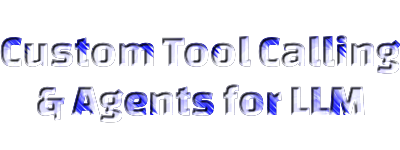

In [2]:
!pip install langchain
!pip install langchain_core
!pip install pydantic
!pip install langchain_groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00


Import chat model


In [3]:
from google.colab import userdata
groq_key= userdata.get('groq')

In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0.9, model_name="Llama3-70b-8192", groq_api_key=groq_key)


In [5]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x785868cbc2b0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x785868c90a60>, model_name='Llama3-70b-8192', temperature=0.9, groq_api_key=SecretStr('**********'))

# Custom Tools

## Custom tool calling with BaseModel Pydantic

In [7]:
from langchain_core.tools import tool
from langchain.pydantic_v1 import BaseModel, Field

@tool
def multiply(x: int, y: int) -> int:
    '''Multiply two numbers together'''
    return x * y

@tool
def add(x: int, y: int) -> int:
    '''Add two numbers together'''
    return x + y

class Multiply(BaseModel):
    '''Multiply two numbers together'''
    a: int = Field(description="first number")
    b: int = Field(description="second number")

class Add(BaseModel):
    '''Add two numbers together'''
    a: int = Field(description="first number")
    b: int = Field(description="second number")


Tools1 = [multiply, add]
bindLlm1 = llm.bind_tools(Tools1)

Tools2 = [Multiply, Add]
bindLlm2 = llm.bind_tools(Tools2)

query = "What is 2 multiplied by 3, then adds 5?"
result1 = bindLlm1.invoke(query)
print(result1.tool_calls)

result2 = bindLlm2.invoke(query)
print(result2.tool_calls)

[{'name': 'multiply', 'args': {'x': 2, 'y': 3}, 'id': 'call_3zxg'}, {'name': 'add', 'args': {'x': 6, 'y': 5}, 'id': 'call_045p'}]
[{'name': 'Multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_2y91'}, {'name': 'Add', 'args': {'a': 6, 'b': 5}, 'id': 'call_5j2p'}]


## Custom tool calling and invoke using StructuredTool

In [8]:
from langchain_core.tools import StructuredTool
from langchain.pydantic_v1 import BaseModel, Field

class Input(BaseModel):
    a: int = Field(description="first number")
    b: int = Field(description="second number")

def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


calculator = StructuredTool.from_function(
    func=multiply,
    name="Calculator",
    description="multiply numbers",
    args_schema=Input,
    return_direct=True,
    # coroutine= ... <- you can specify an async method if desired as well
)

print(calculator.invoke({"a": 2, "b": 3}))
print(calculator.name)
print(calculator.description)
print(calculator.args)

6
Calculator
multiply numbers
{'a': {'title': 'A', 'description': 'first number', 'type': 'integer'}, 'b': {'title': 'B', 'description': 'second number', 'type': 'integer'}}


# Agents

In [9]:
from langchain_core.tools import tool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.agents import AgentExecutor, create_tool_calling_agent, tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def length(s: str) -> int:
    """Return the length of a string."""
    return len(s)

Tools = [multiply,length]
promt = ChatPromptTemplate.from_messages(
    [
        ('system', 'You are a helpful assistant'),
        ('human', '{input}'),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

bindllm = llm.bind_tools(Tools)

agent = create_tool_calling_agent(bindllm, Tools, prompt=promt)

agent_executor = AgentExecutor(agent=agent, tools=Tools, verbose=True)

query = "What is 2 multiplied by 3 and lenth of word 'computer'?"
input = {"input": query}
result = agent_executor.invoke(input)
print(result)



> Entering new AgentExecutor chain...

Invoking: `multiply` with `{'a': 2, 'b': 3}`


6
Invoking: `length` with `{'s': 'computer'}`


8The answer to your question is: 2 multiplied by 3 is 6 and the length of the word 'computer' is 8.

> Finished chain.
{'input': "What is 2 multiplied by 3 and lenth of word 'computer'?", 'output': "The answer to your question is: 2 multiplied by 3 is 6 and the length of the word 'computer' is 8."}
